# Statistical Methods Project

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats.mstats import winsorize
import statsmodels.formula.api as smf
import statsmodels.api as sm

# EDA (data description, data preprocessing)

In [26]:
df = pd.read_csv("https://raw.githubusercontent.com/ov3ipo/SM_Project/main/life_expectancy.csv")
# remove trailing space in columns name and format display function
pd.options.display.float_format = '{:.4f}'.format
df = df.rename(columns=lambda x: x.strip())

# overview on data statistic
display(df.head(10))
display(df.info())

# get quantitative and qualitative data
numeric_cols = df.drop(columns=["Status", "Country"], axis=1).columns

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0000,263.0000,62,0.0100,71.2796,65.0000,1154,...,6.0000,8.1600,65.0000,0.1000,584.2592,33736494.0000,17.2000,17.3000,0.4790,10.1000
1,Afghanistan,2014,Developing,59.9000,271.0000,64,0.0100,73.5236,62.0000,492,...,58.0000,8.1800,62.0000,0.1000,612.6965,327582.0000,17.5000,17.5000,0.4760,10.0000
2,Afghanistan,2013,Developing,59.9000,268.0000,66,0.0100,73.2192,64.0000,430,...,62.0000,8.1300,64.0000,0.1000,631.7450,31731688.0000,17.7000,17.7000,0.4700,9.9000
3,Afghanistan,2012,Developing,59.5000,272.0000,69,0.0100,78.1842,67.0000,2787,...,67.0000,8.5200,67.0000,0.1000,669.9590,3696958.0000,17.9000,18.0000,0.4630,9.8000
4,Afghanistan,2011,Developing,59.2000,275.0000,71,0.0100,7.0971,68.0000,3013,...,68.0000,7.8700,68.0000,0.1000,63.5372,2978599.0000,18.2000,18.2000,0.4540,9.5000
5,Afghanistan,2010,Developing,58.8000,279.0000,74,0.0100,79.6794,66.0000,1989,...,66.0000,9.2000,66.0000,0.1000,553.3289,2883167.0000,18.4000,18.4000,0.4480,9.2000
6,Afghanistan,2009,Developing,58.6000,281.0000,77,0.0100,56.7622,63.0000,2861,...,63.0000,9.4200,63.0000,0.1000,445.8933,284331.0000,18.6000,18.7000,0.4340,8.9000
7,Afghanistan,2008,Developing,58.1000,287.0000,80,0.0300,25.8739,64.0000,1599,...,64.0000,8.3300,64.0000,0.1000,373.3611,2729431.0000,18.8000,18.9000,0.4330,8.7000
8,Afghanistan,2007,Developing,57.5000,295.0000,82,0.0200,10.9102,63.0000,1141,...,63.0000,6.7300,63.0000,0.1000,369.8358,26616792.0000,19.0000,19.1000,0.4150,8.4000
9,Afghanistan,2006,Developing,57.3000,295.0000,84,0.0300,17.1715,64.0000,1990,...,58.0000,7.4300,58.0000,0.1000,272.5638,2589345.0000,19.2000,19.3000,0.4050,8.1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

None

## Data description

### Univariate

#### Qualitative

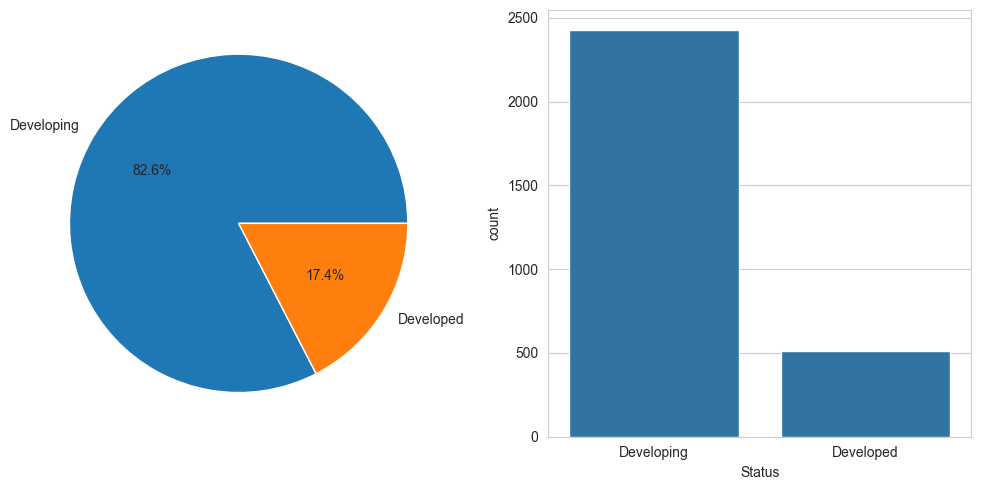

In [27]:
plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
x = df['Status'].value_counts().reset_index()
plt.pie(x=x['count'], labels=x['Status'], autopct="%0.1f%%")
plt.subplot(1, 2, 2)
sns.countplot(df, x="Status")
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- Why didn't we consider the Country col in this case?
- State what you see in the chart
```

#### Quantitative

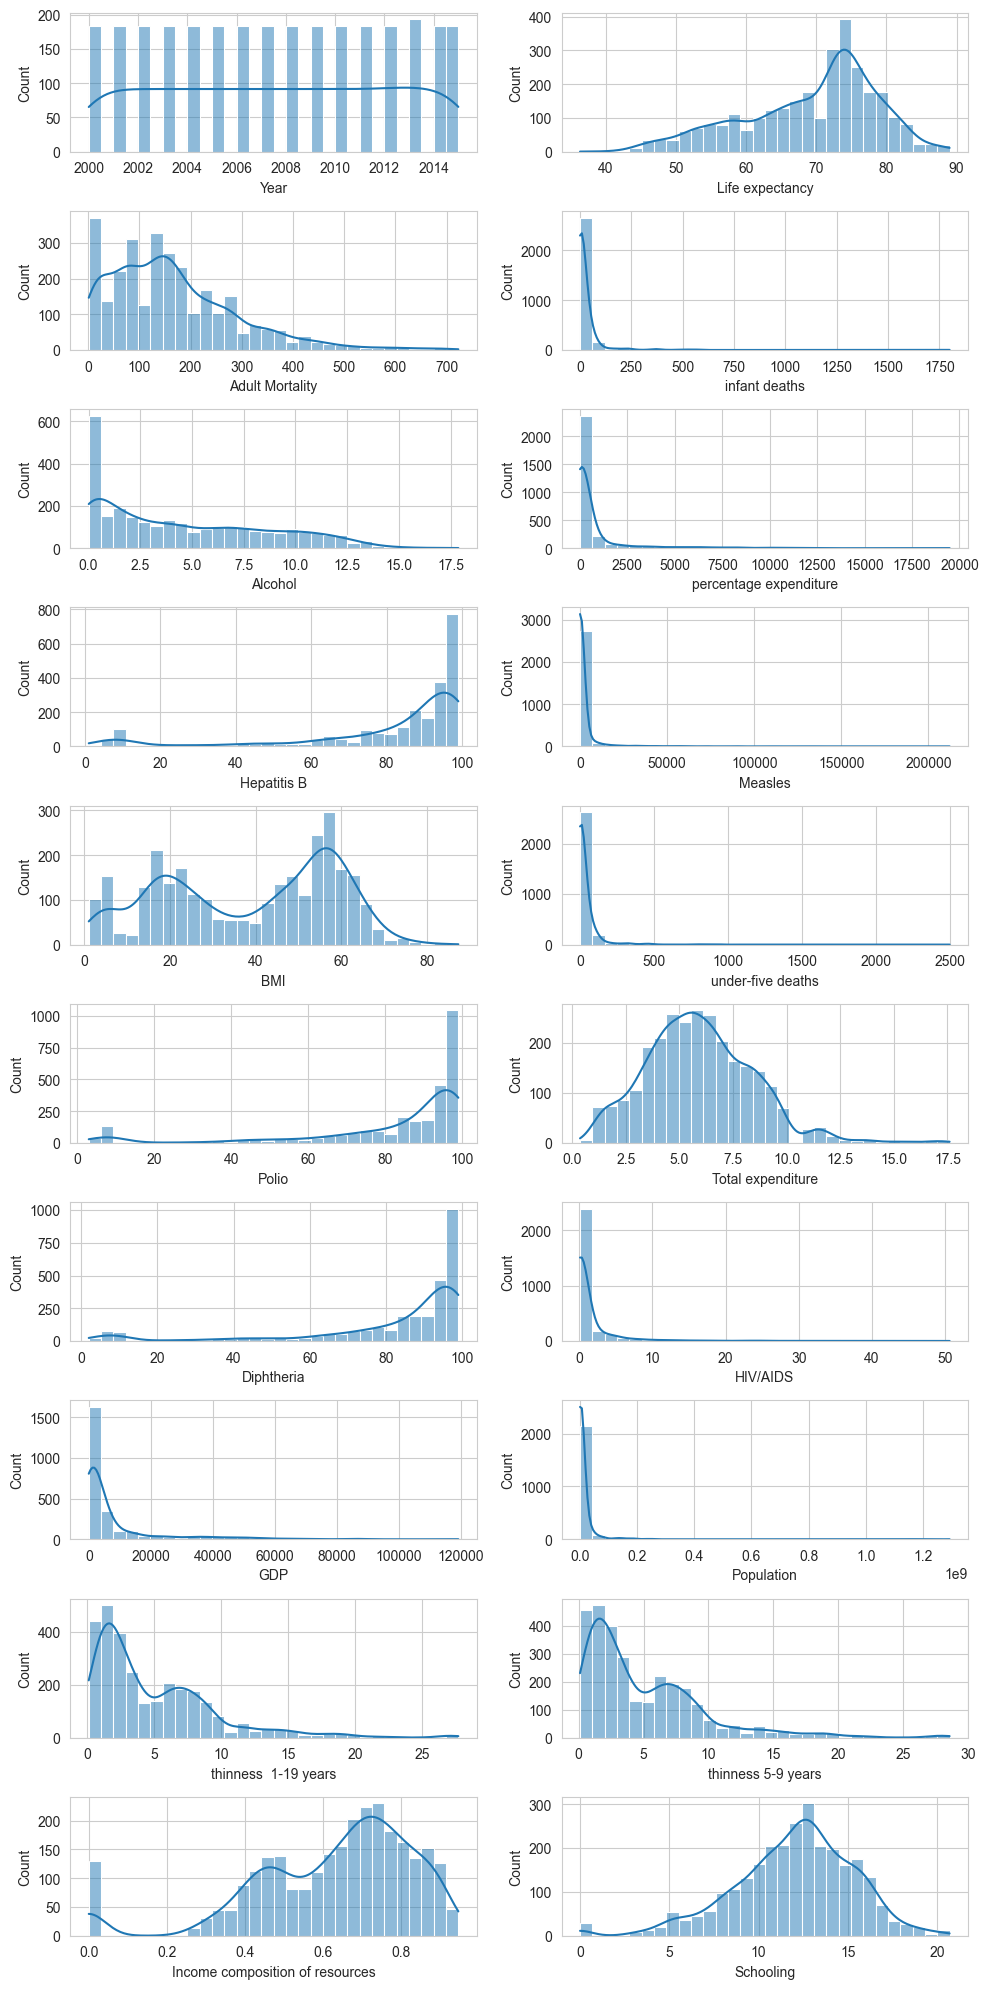

In [28]:
plt.figure(figsize=(10, 20))
for i, col in enumerate(numeric_cols):
    plt.subplot(10, 2, i + 1)
    sns.histplot(df, x=col, bins=30, kde=True)
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- State what you see in the chart
```

### Bivariate

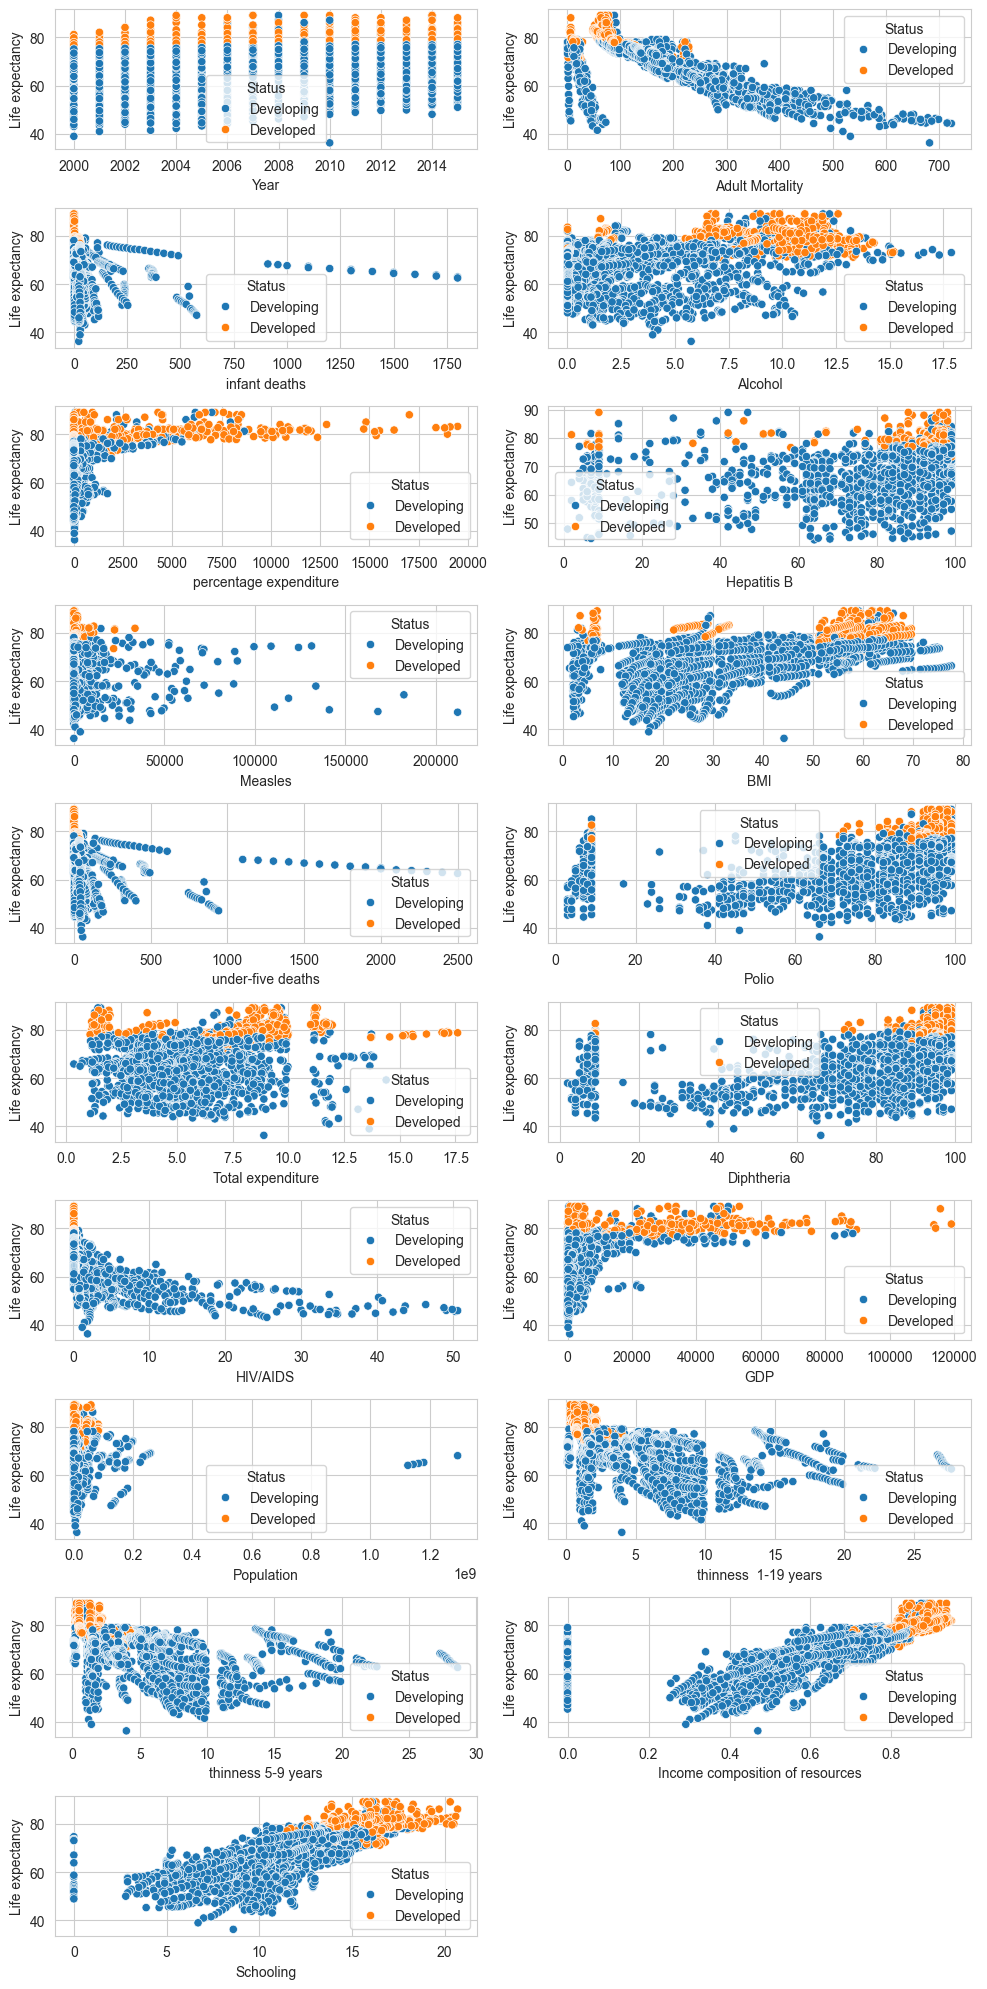

In [29]:
plt.figure(figsize=(10, 20))
index = np.argwhere(numeric_cols=="Life expectancy")
for i, col in enumerate(np.delete(numeric_cols, index)):
    plt.subplot(10, 2, i + 1)
    sns.scatterplot(df, x=col, y="Life expectancy", hue="Status", legend="auto")
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- State what you see in the chart
- Base on the scatter plot can you spot any variables that seem to have a linear relationship with the target variabel?
```

### Overall statistic

In [30]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Year,2938.0000,2007.5187,4.6138,2000.0000,2004.0000,2008.0000,2012.0000,2015.0000
Life expectancy,2928.0000,69.2249,9.5239,36.3000,63.1000,72.1000,75.7000,89.0000
Adult Mortality,2928.0000,164.7964,124.2921,1.0000,74.0000,144.0000,228.0000,723.0000
infant deaths,2938.0000,30.3039,117.9265,0.0000,0.0000,3.0000,22.0000,1800.0000
Alcohol,2744.0000,4.6029,4.0524,0.0100,0.8775,3.7550,7.7025,17.8700
percentage expenditure,2938.0000,738.2513,1987.9149,0.0000,4.6853,64.9129,441.5341,19479.9116
Hepatitis B,2385.0000,80.9405,25.0700,1.0000,77.0000,92.0000,97.0000,99.0000
Measles,2938.0000,2419.5922,11467.2725,0.0000,0.0000,17.0000,360.2500,212183.0000
BMI,2904.0000,38.3212,20.0440,1.0000,19.3000,43.5000,56.2000,87.3000
under-five deaths,2938.0000,42.0357,160.4455,0.0000,0.0000,4.0000,28.0000,2500.0000


## Data preprocessing (NAs, outliers, duplicateds, label encoding)

### Missing

In [31]:
print("\nPreprocessing\n")
print(df.isna().sum())
df = df.interpolate(method='linear', limit_direction='forward')
print("\nPostprocessing\n")
print(df.isna().sum())


Preprocessing

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

Postprocessing

Country                            0
Year                               0
Status                

C:\Users\Hii\AppData\Local\Temp\ipykernel_10172\2977670138.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='forward')


### Duplicated

In [32]:
print(f"Total duplicated values: {df.duplicated().sum()}")

Total duplicated values: 0


### Outliers

#### Detect outliers

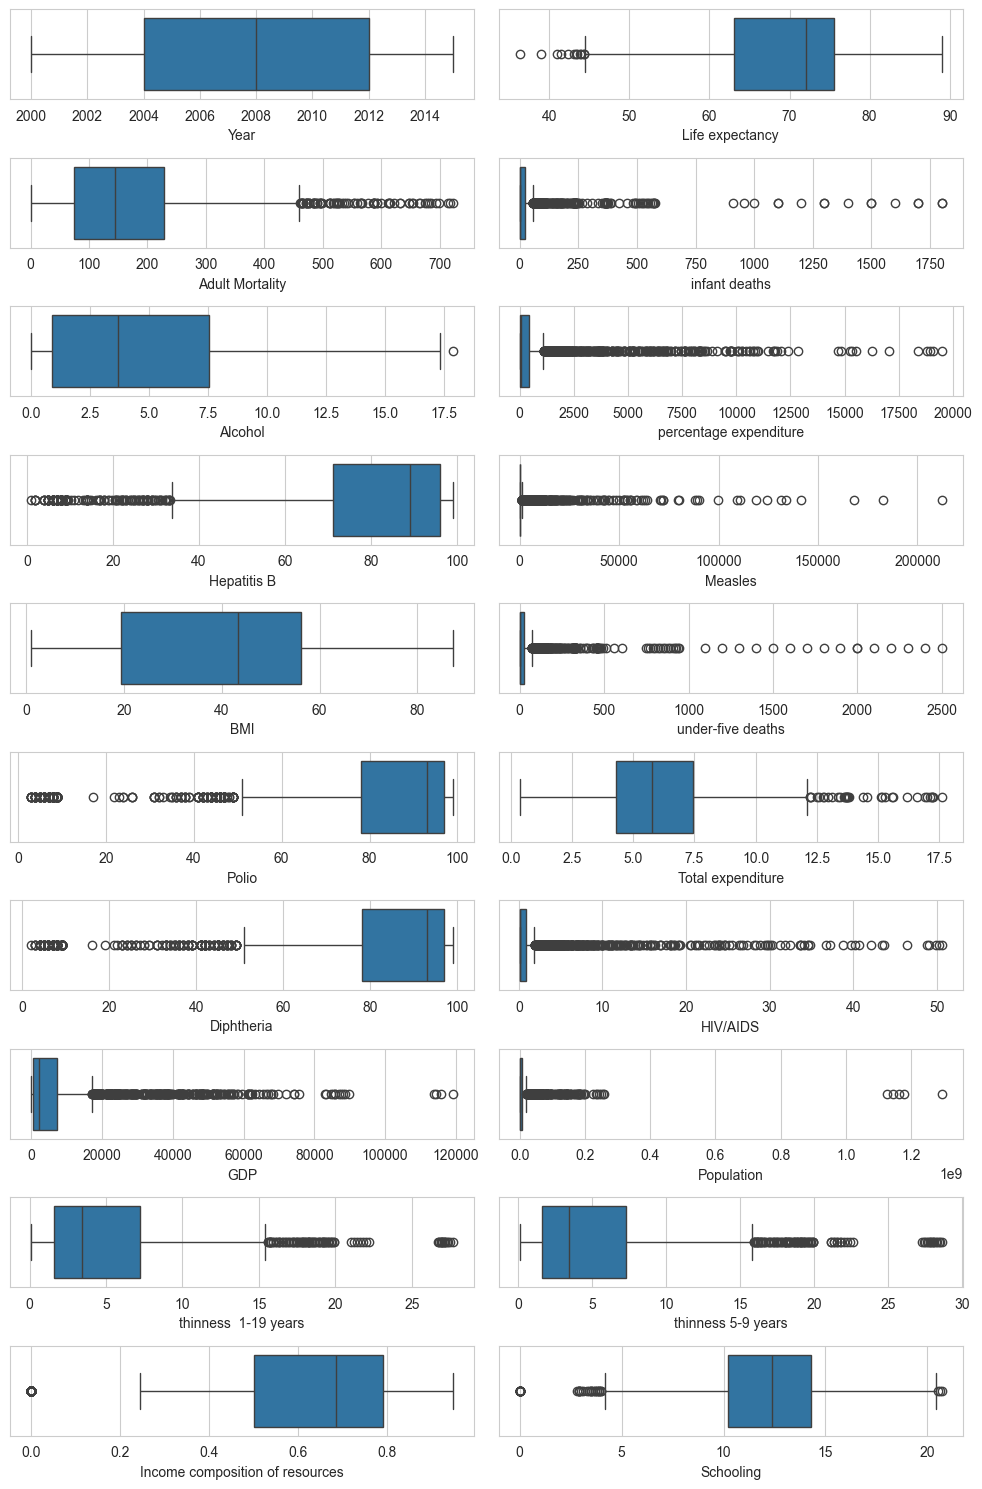

,Total outliers
Year,0
Life expectancy,12
Adult Mortality,82
infant deaths,315
Alcohol,1
percentage expenditure,389
Hepatitis B,248
Measles,542
BMI,0
under-five deaths,394


In [33]:
plt.figure(figsize=(10, 15))
for i, col in enumerate(numeric_cols):
    plt.subplot(10, 2, i + 1)
    sns.boxplot(df, x=col)
plt.tight_layout()
plt.show()

# detect outliers
def detectOutliers(data):
    outliers_arr = []
    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col].count()
        outliers_arr.append(outliers)
    return pd.DataFrame(outliers_arr, index=data.columns, columns=["Total outliers"])

numeric_data = df.drop(columns=["Status", "Country"], axis=1)
outliers = detectOutliers(numeric_data)
outliers

``` {markdonw}
Why we should not use variable with high outliers -> because regression can heavily be affected by these outliers, hence we should only choose those with low outliers
Potential variable for regression of target
- Year
- Adult Mortality
- Alcohol
- BMI
- Total expenditure
- thinness 1-19 years
- thinness 5-9 years
- Income composition of resources
- Schooling
```

#### Dealing with outliers

In [34]:
    # get potentital variables and variables that have outliers
    potential_var = outliers[(outliers["Total outliers"] < 150)].index
    outliers_var = outliers[(outliers["Total outliers"] > 0) & (outliers["Total outliers"] < 150)].index
    
    # using transformation to deal with outliers
    df_outliers = df.copy()
    for col in outliers_var:
        if col != "Life expectancy":
            df_outliers[col] = np.sqrt(df_outliers[col])
    
    # detect outliers again
    display(detectOutliers(df_outliers[potential_var]))
    
    # notice that outliers of Total expenditure, Income composition of resources and schooling does not change and or increase
    for col in ["Total expenditure", "Income composition of resources", "Schooling"]:
        df_outliers[col] = df[col]
        df_outliers[col] = winsorize(df_outliers[col], limits=[0.05, 0.05])
    
    # detect outliers again
    display(detectOutliers(df_outliers[potential_var]))

,Total outliers
Year,0
Life expectancy,12
Adult Mortality,18
Alcohol,0
BMI,0
Total expenditure,46
thinness 1-19 years,16
thinness 5-9 years,16
Income composition of resources,130
Schooling,107


,Total outliers
Year,0
Life expectancy,12
Adult Mortality,18
Alcohol,0
BMI,0
Total expenditure,0
thinness 1-19 years,16
thinness 5-9 years,16
Income composition of resources,0
Schooling,0


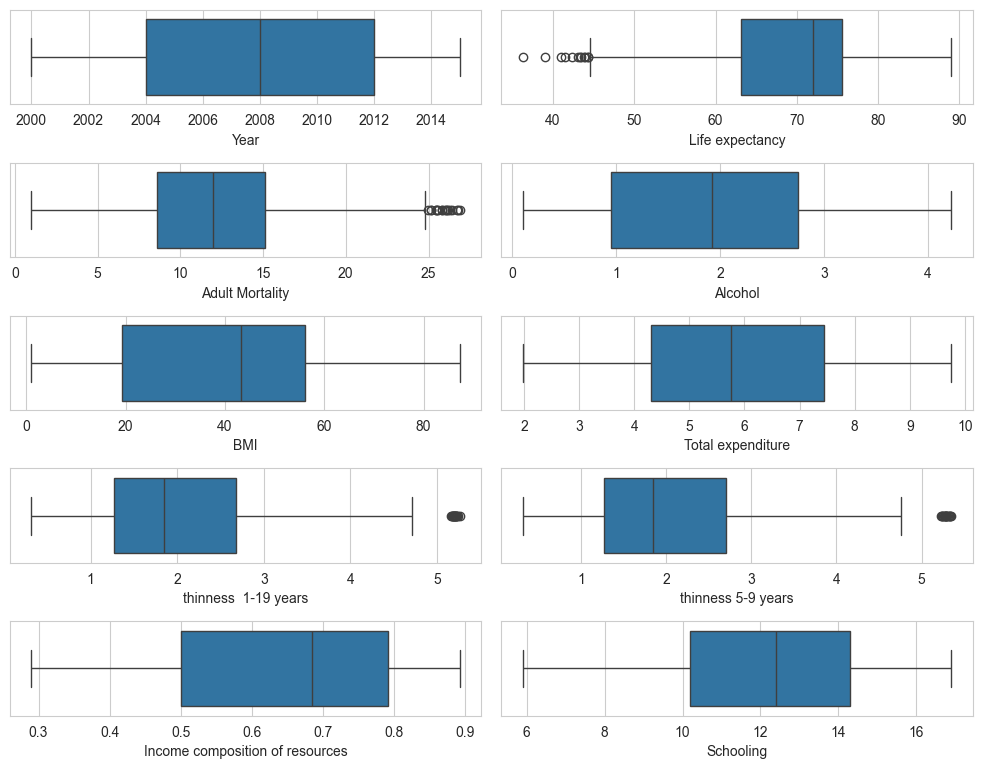

In [35]:
# plot outliers
plt.figure(figsize=(10, 15))
for i, col in enumerate(potential_var):
    plt.subplot(10, 2, i + 1)
    sns.boxplot(df_outliers, x=col)
plt.tight_layout()
plt.show()

# assign new dataframe to use for regression
df_regress = df_outliers[potential_var]

``` {markdown}
Remark
- Explain reason why we should not use variables that have many outliers
- Explain reason why we choose to use transformation and why is log (or anything else)
```

### Comprare preprocess and postprocess

In [36]:
# compare statistic
display(df[potential_var].describe().T)
display(df_regress.describe().T)

,count,mean,std,min,25%,50%,75%,max
Year,2938.0000,2007.5187,4.6138,2000.0000,2004.0000,2008.0000,2012.0000,2015.0000
Life expectancy,2938.0000,69.2149,9.5108,36.3000,63.1000,72.0000,75.6000,89.0000
Adult Mortality,2938.0000,164.7446,124.2266,1.0000,74.0000,144.0000,228.0000,723.0000
Alcohol,2938.0000,4.5502,3.9948,0.0100,0.9025,3.7025,7.5500,17.8700
BMI,2938.0000,38.2987,19.9914,1.0000,19.3250,43.2500,56.1000,87.3000
Total expenditure,2938.0000,5.9406,2.4457,0.3700,4.3125,5.7550,7.4400,17.6000
thinness 1-19 years,2938.0000,4.8823,4.4334,0.1000,1.6000,3.4000,7.2000,27.7000
thinness 5-9 years,2938.0000,4.9204,4.5325,0.1000,1.6000,3.4000,7.3000,28.6000
Income composition of resources,2938.0000,0.6344,0.2096,0.0000,0.5000,0.6840,0.7911,0.9480
Schooling,2938.0000,12.0752,3.3430,0.0000,10.2000,12.4000,14.3000,20.7000


,count,mean,std,min,25%,50%,75%,max
Year,2938.0000,2007.5187,4.6138,2000.0000,2004.0000,2008.0000,2012.0000,2015.0000
Life expectancy,2938.0000,69.2149,9.5108,36.3000,63.1000,72.0000,75.6000,89.0000
Adult Mortality,2938.0000,11.8344,4.9700,1.0000,8.6023,12.0000,15.0997,26.8887
Alcohol,2938.0000,1.8375,1.0836,0.1000,0.9500,1.9242,2.7477,4.2273
BMI,2938.0000,38.2987,19.9914,1.0000,19.3250,43.2500,56.1000,87.3000
Total expenditure,2938.0000,5.8642,2.1513,1.9800,4.3125,5.7550,7.4400,9.7500
thinness 1-19 years,2938.0000,1.9989,0.9417,0.3162,1.2649,1.8439,2.6833,5.2631
thinness 5-9 years,2938.0000,2.0007,0.9582,0.3162,1.2649,1.8439,2.7019,5.3479
Income composition of resources,2938.0000,0.6464,0.1750,0.2900,0.5000,0.6840,0.7911,0.8920
Schooling,2938.0000,12.1127,2.9745,5.9000,10.2000,12.4000,14.3000,16.9000


``` {markdown}
Remark:
- State what you observe when compare the two tables
```

# Linear Regression Analysis

## Correlation Matrix

### Before dealing with outliers

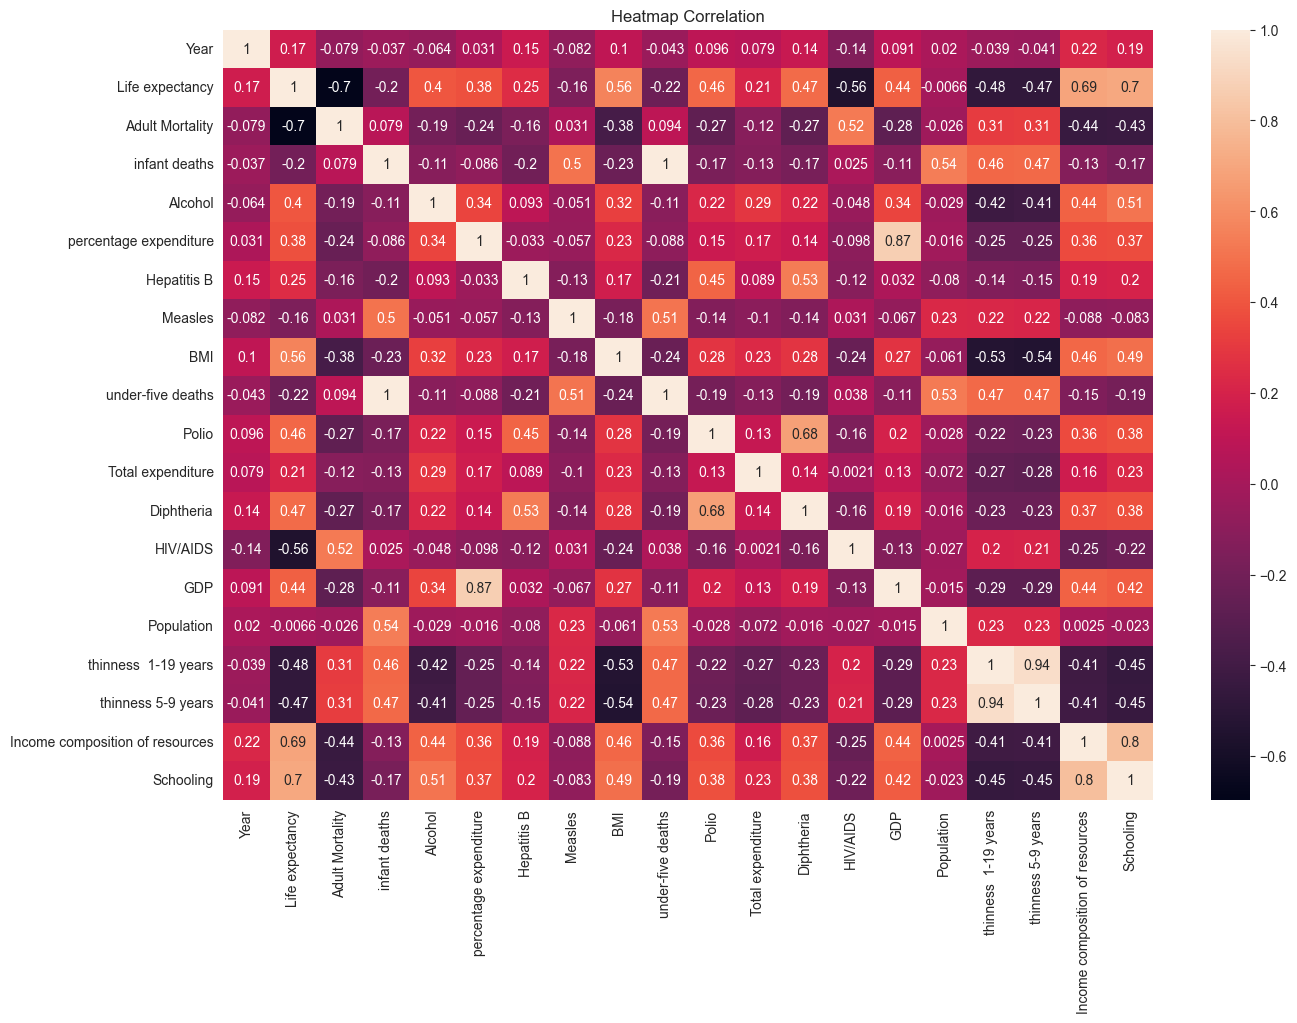

Variables have correlation larger than 0.5: 


Adult Mortality                   -0.6957
BMI                                0.5564
HIV/AIDS                          -0.5559
Income composition of resources    0.6909
Schooling                          0.7043
Name: Life expectancy, dtype: float64

In [37]:
numeric_df = df.drop(columns=["Country", "Status"])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df.corr(), annot=True)
plt.title('Heatmap Correlation')
plt.show()

# get variables that has high correlation with Life expectancy
corrs = numeric_df.corr()['Life expectancy'].drop('Life expectancy')
high_corr = corrs[corrs.abs() > 0.5]
print("Variables have correlation larger than 0.5: ")
high_corr

### After dealing with outliers

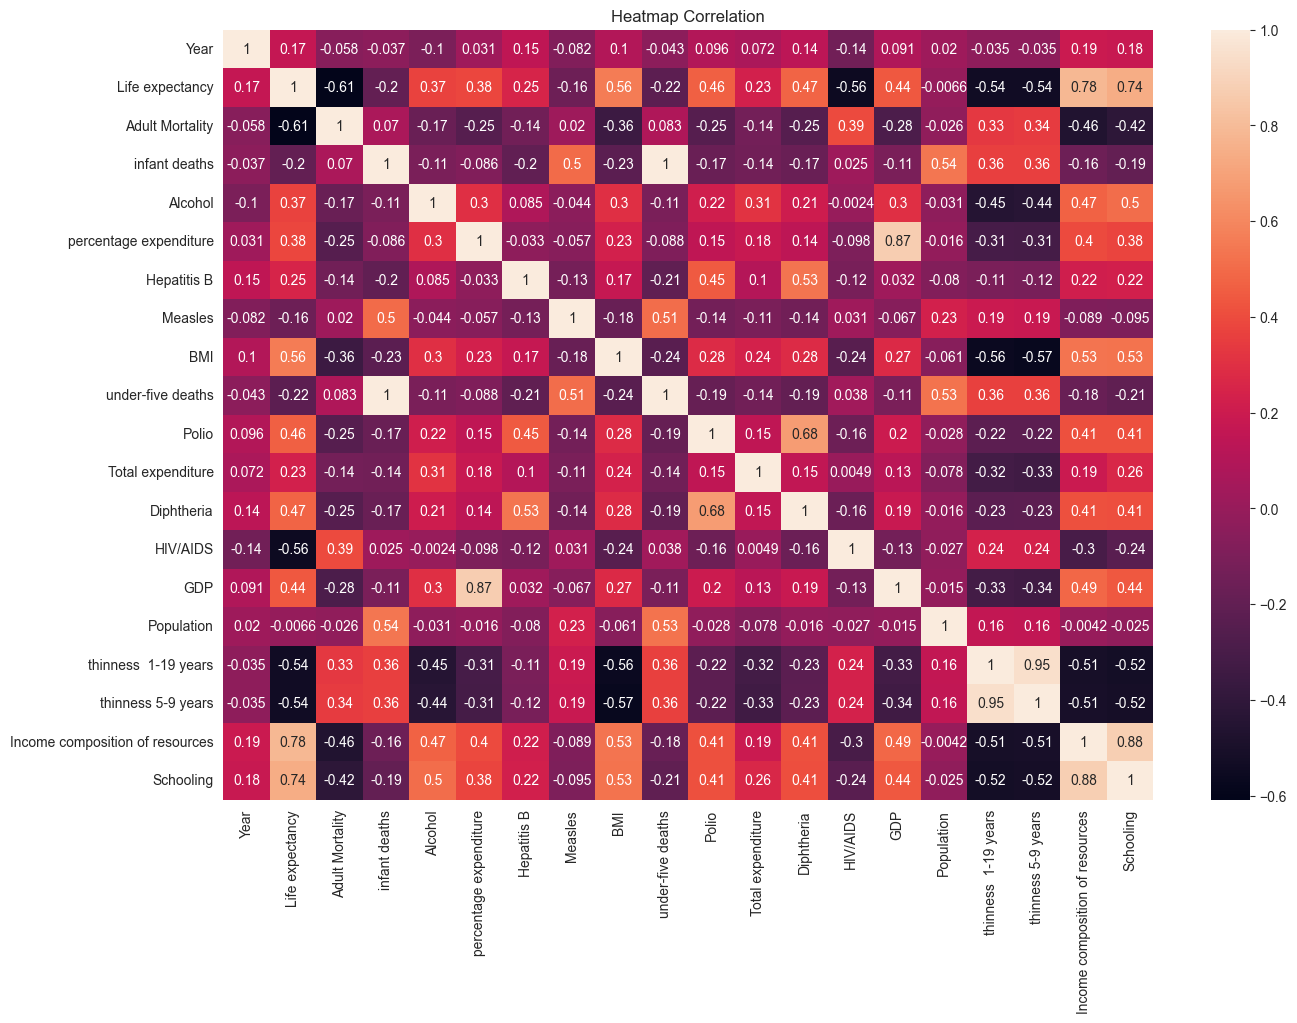

Variables have correlation larger than 0.5: 


Adult Mortality                   -0.6085
BMI                                0.5564
HIV/AIDS                          -0.5559
thinness  1-19 years              -0.5355
thinness 5-9 years                -0.5379
Income composition of resources    0.7837
Schooling                          0.7375
Name: Life expectancy, dtype: float64

In [38]:
numeric_df_outliers = df_outliers.drop(columns=["Country", "Status"])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df_outliers.corr(), annot=True)
plt.title('Heatmap Correlation')
plt.show()

# get variables that has high correlation with Life expectancy
corrs = numeric_df_outliers.corr()['Life expectancy'].drop('Life expectancy')
high_corr = corrs[corrs.abs() > 0.5]
print("Variables have correlation larger than 0.5: ")
high_corr

In [39]:
# update data use for regress
df_regress = df_regress[["Life expectancy", "BMI", "Adult Mortality"]]

``` {markdown}
Remark
- Base on qualitative analysis remark, outliers detection remark, and this correlation matix make the final conclusion on which variable we should use for linear regression of target
- thiness 1-19 and 5-9 have high correlation with each other, also for income composition of resources make them not satisfy the condition of linear regression that is each variables should be independent
- HIV/AIDS is introduced in here but it has too much outliers hence we will skip it
- This leaves us with the last 2 variables that is BMI and Adult Mortality, hence we will use them for linear regression
```

## Least square regression

In [40]:
X1 = df_regress['Adult Mortality']
X2 = df_regress['BMI']
y = df_regress['Life expectancy']

model1 = smf.ols(formula='y ~ X1', data=df_regress).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     1726.
Date:                Mon, 03 Jun 2024   Prob (F-statistic):          3.98e-297
Time:                        10:11:18   Log-Likelihood:                -10107.
No. Observations:                2938   AIC:                         2.022e+04
Df Residuals:                    2936   BIC:                         2.023e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     82.9944      0.360    230.707      0.0

In [41]:
model2 = smf.ols(formula='y ~ X2', data=df_regress).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     1317.
Date:                Mon, 03 Jun 2024   Prob (F-statistic):          1.61e-238
Time:                        10:11:18   Log-Likelihood:                -10242.
No. Observations:                2938   AIC:                         2.049e+04
Df Residuals:                    2936   BIC:                         2.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.0764      0.315    187.448      0.0

In [42]:
model3 = smf.ols(formula='y ~ X1 + X2', data=df_regress).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     1481.
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        10:11:18   Log-Likelihood:                -9760.8
No. Observations:                2938   AIC:                         1.953e+04
Df Residuals:                    2935   BIC:                         1.955e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.7670      0.486    149.622      0.0

## Check residuals for 4 assumptions

### Assumption 1: Linearity

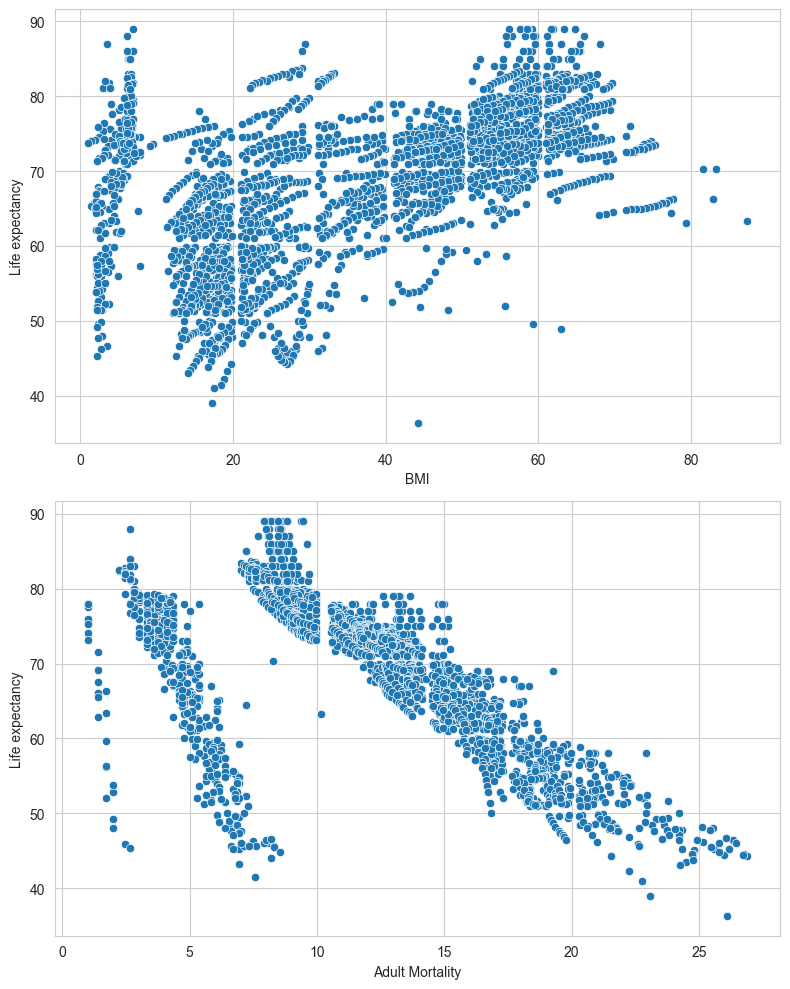

In [43]:
plt.figure(figsize=(8, 10))
for i, col in enumerate(df_regress.drop(['Life expectancy'], axis=1).columns):
    plt.subplot(2, 1, i + 1)
    sns.scatterplot(df_regress, x=col, y="Life expectancy")
plt.tight_layout()
plt.show()

``` {markdonw}
Remark
- What does the chart conclude about the liearity?
- What to do if this assumption is violated?
```

### Assumption 2: Independent

``` {markdonw}
Remark
- What does the chart conclude about the linearity?
- What to do if this assumption is violated?
```

### Assumption 3: Homoscedasticity

``` {markdonw}
Remark
- What does the chart conclude about the linearity?
- What to do if this assumption is violated?
```

### Assumption 4: Normality of Residuals

In [44]:
# test = shapiro(df_regress[])
# print(f'Test statistic = {test[0]}, p-value = {test[1]}')
# if test[1] > 0.05: print(f'{col} looks normal distributed (fail to reject H0)\n')
# else: print(f'{col} does not normal distributed (reject H0)\n')

``` {markdonw}
Remark
- What does the chart conclude about the linearity?
- What to do if this assumption is violated?
```

## Normality check

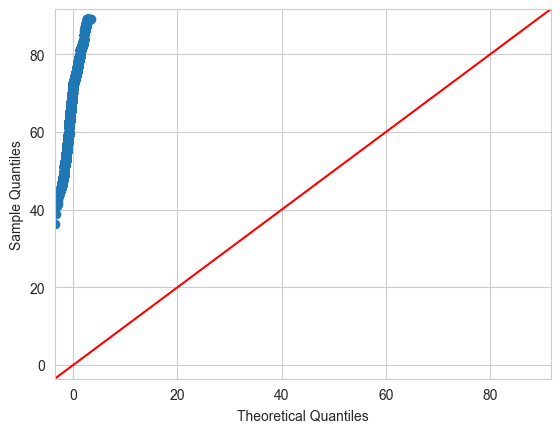

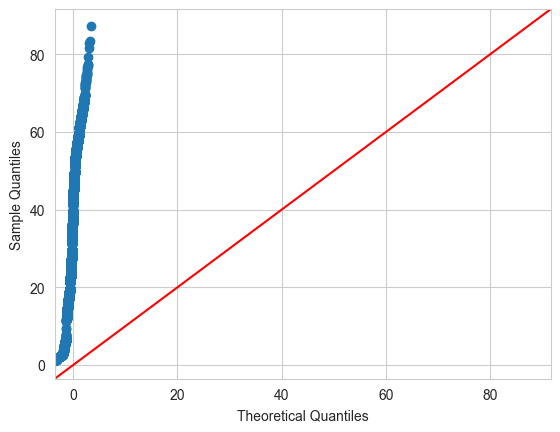

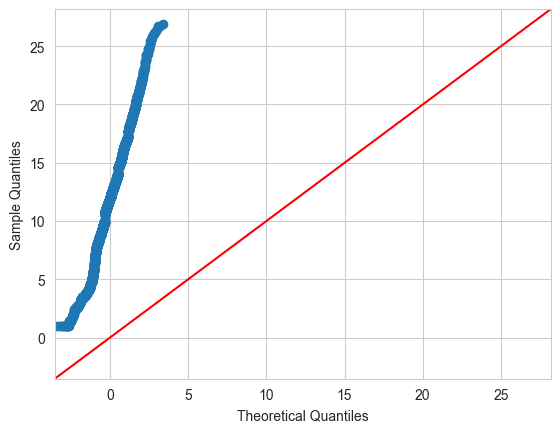

In [45]:
# add semicolon to prevent duplicated graph issue
sm.qqplot(df_regress["Life expectancy"], line='45');
sm.qqplot(df_regress['BMI'], line='45');
sm.qqplot(df_regress['Adult Mortality'], line='45');

In [46]:
# use Shapiro-Wilk test to test again
for col in df_regress.columns:
    test = shapiro(df_regress[col])
    print(f'Test statistic = {test[0]}, p-value = {test[1]}')
    if test[1] > 0.05: print(f'{col} looks normal distributed (fail to reject H0)\n')
    else: print(f'{col} does not normal distributed (reject H0)\n')

Test statistic = 0.9566212771358409, p-value = 9.704783341258267e-29
Life expectancy does not normal distributed (reject H0)

Test statistic = 0.9312720150595797, p-value = 8.652378014696785e-35
BMI does not normal distributed (reject H0)

Test statistic = 0.9896294475629359, p-value = 8.478434350053438e-14
Adult Mortality does not normal distributed (reject H0)


0      65.0000
1      59.9000
2      59.9000
3      59.5000
4      59.2000
         ...  
2933   44.3000
2934   44.5000
2935   44.8000
2936   45.3000
2937   46.0000
Name: Life expectancy, Length: 2938, dtype: float64


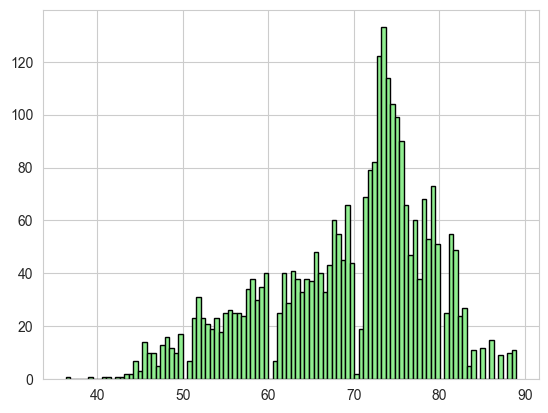

In [47]:
import matplotlib.pyplot as plt
data = df_regress['Life expectancy']
plt.hist(data, color='lightgreen', ec='black', bins=100)
print(data)

36.3 89.0
[-0.43971228 -0.6950633  -0.6950633  ... -2.53086969 -2.42123694
 -2.15445218]
Statistics=48.671, p=0.000
Sample does not look Gaussian (reject H0)


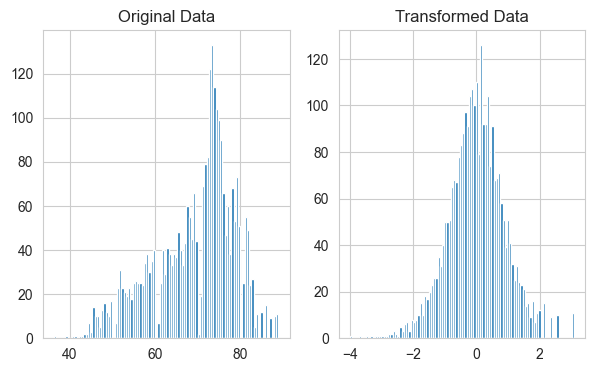

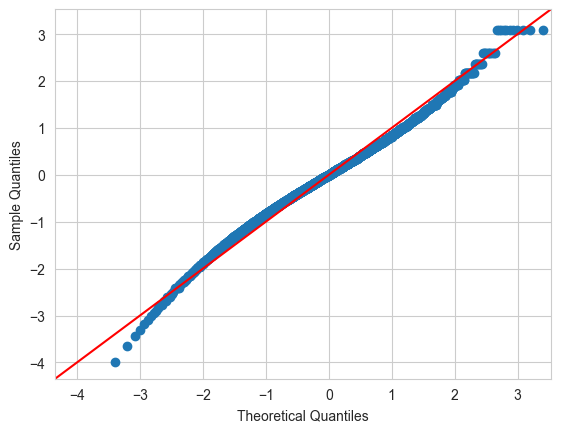

In [48]:
x = df_regress['Life expectancy']
n = len(x)
from scipy import stats
y = (stats.rankdata(x)/(n+1))*2 -1
print(np.min(x), np.max(x))
y = np.arctanh(y)
y = np.asarray(y)
print(y)


fig,ax = plt.subplots(1,2,figsize = (7,4))
ax[0].hist(x,bins=100 )
ax[0].set_title('Original Data')
ax[1].hist(y,bins=100 )
ax[1].set_title('Transformed Data')
sm.qqplot(y, line='45');
from scipy.stats import normaltest
stat, p = normaltest(y)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
 print('Sample looks Gaussian (fail to reject H0)')
else:
 print('Sample does not look Gaussian (reject H0)')

-3.992742178366946 3.9927421783668646
0      19.1000
1      18.6000
2      18.1000
3      17.6000
4      17.2000
         ...  
2933   27.1000
2934   26.7000
2935   26.3000
2936   25.9000
2937   25.5000
Name: BMI, Length: 2938, dtype: float64


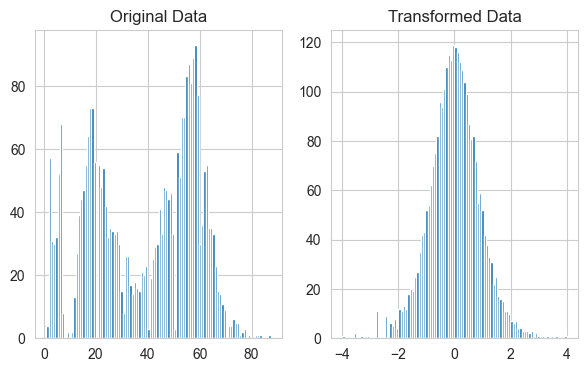

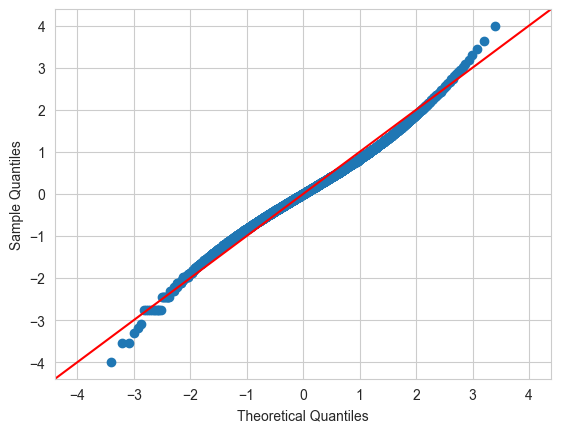

In [49]:

x1 = df_regress['BMI']
n1 = len(x1)

y1 = (stats.rankdata(x1)/(n+1))*2 -1

y1 = np.arctanh(y1)
print(np.min(y1), np.max(y1))
print(x1)


fig,ax = plt.subplots(1,2,figsize = (7,4))
ax[0].hist(x1,bins=100 )
ax[0].set_title('Original Data')
ax[1].hist(y1,bins=100 )
ax[1].set_title('Transformed Data')
sm.qqplot(y1, line='45');


-3.056755990775415 3.096862443752885
0      16.2173
1      16.4621
2      16.3707
3      16.4924
4      16.5831
         ...  
2933   26.8887
2934   26.7395
2935    8.5440
2936   26.1916
2937   25.7876
Name: Adult Mortality, Length: 2938, dtype: float64


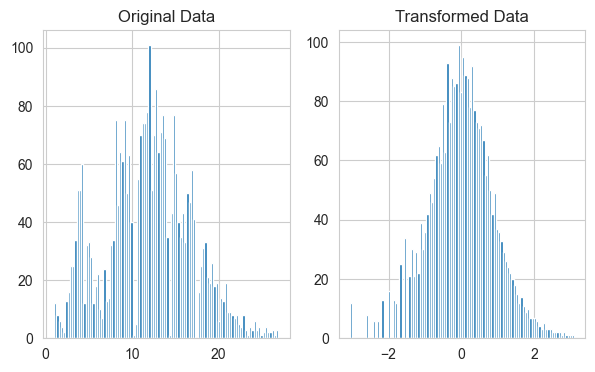

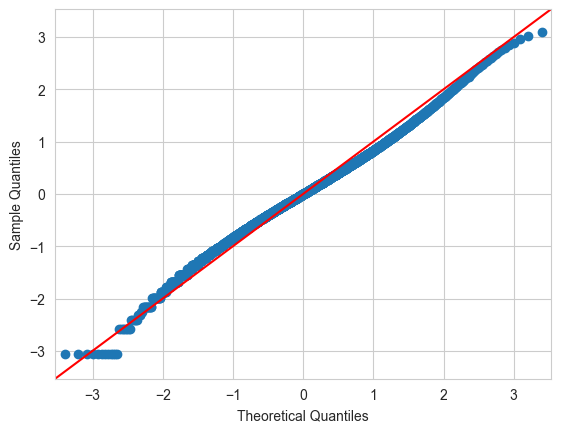

In [50]:
x2 = df_regress['Adult Mortality']
n2 = len(x)

y2 = (stats.rankdata(x2)/(n+6))*2 -1

y2 = np.arctanh(y2)
print(np.min(y2), np.max(y2))


print(x2)


fig,ax = plt.subplots(1,2,figsize = (7,4))
ax[0].hist(x2,bins=100 )
ax[0].set_title('Original Data')
ax[1].hist(y2,bins=100 )
ax[1].set_title('Transformed Data')
sm.qqplot(y2, line='45');

``` {markdown}
Remark
- State what you see and what to do next?
```

## Construct confidence interval

##### The confident interval for mean

In [51]:
confidence_level = 0.95
def CI_mean(data, name):

  data1 = data.values
  data_mean = np.mean(data1)
  data_std = np.std(data1, ddof=1)
  n = len(data1)
  data_interval = stats.t.interval(confidence_level, df = n-1, loc = data_mean, scale = data_std/np.sqrt(n))
  print(f"95% Confident that the mean of {name} lie between {data_interval}")
CI_mean(df_regress['BMI'], "BMI")
CI_mean(df_regress['Adult Mortality'], 'Adult Mortality')
CI_mean(df_regress['Life expectancy'], 'Life expectancy')


95% Confident that the mean of BMI lie between (37.57551288481066, 39.0218662846924)
95% Confident that the mean of Adult Mortality lie between (11.654588740555539, 12.014159616474146)
95% Confident that the mean of Life expectancy lie between (68.87082598319594, 69.55892214478226)


##### Confident interval for variance and standard deviation

In [52]:
confidence_level = 0.95
def CI_var_std(data, name):
  data_var = np.var(data, ddof = 1)
  data_std = np.std(data, ddof =1)
  n = len(data) - 1
  chi2 = stats.chi2.ppf((1 + confidence_level)/2, n)
  CI_var = (n * data_var / chi2, n * data_var / stats.chi2.ppf((1-confidence_level)/2,n))
  CI_std = np.sqrt(CI_var)
  print(f"95% Confident that Variance of {name} lie between {CI_var} :")
  print(f"95% Confident that Standard Deviation of {name} lie between {CI_std} :")
CI_var_std(df_regress['BMI'], 'BMI')
CI_var_std(df_regress['Adult Mortality'], 'Adult Mortality')
CI_var_std(df_regress['Life expectancy'],'Life expectancy' )


95% Confident that Variance of BMI lie between (379.9778619542118, 420.9112361580616) :
95% Confident that Standard Deviation of BMI lie between [19.49302085 20.51612137] :
95% Confident that Variance of Adult Mortality lie between (23.48434594012297, 26.014213115425814) :
95% Confident that Standard Deviation of Adult Mortality lie between [4.846065   5.10041303] :
95% Confident that Variance of Life expectancy lie between (86.00183614962516, 95.26644257492) :
95% Confident that Standard Deviation of Life expectancy lie between [9.27371749 9.76045299] :


##### Confident interval for proportion

In [53]:
confidence_level=0.95
def CI_proportion(data, name):
    n = len(data)
    p = 1/2
    se = np.sqrt(p * (1 - p) / n)
    z = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    lower_bound = p - z * se
    upper_bound = p + z * se
    #return lower_bound, upper_bound
    print(f" 95% Confident that proportion of {name}.... is between ({lower_bound}, {upper_bound})")
CI_proportion(df_regress['Adult Mortality'], 'Adult Mortality')
CI_proportion(df_regress['BMI'], 'BMI')
CI_proportion(df_regress['Life expectancy'], 'Life expectancy')


 95% Confident that proportion of Adult Mortality.... is between (0.48192025921236414, 0.5180797407876359)
 95% Confident that proportion of BMI.... is between (0.48192025921236414, 0.5180797407876359)
 95% Confident that proportion of Life expectancy.... is between (0.48192025921236414, 0.5180797407876359)
